In [69]:
from Column import Column
from Condition import Condition
from Table import Table
from Query import Query
#from Query import other

In [82]:
import pandas as pd

def getLevenshteinDistance(word1: str, word2: str):
    n = len(word1)
    m = len(word2)
    
    # Create matrix (n+1) x (m+1)
    d = [[0] * (m + 1) for _ in range(n + 1)]
    
    # Initialize first column and row
    for i in range(n + 1):
        d[i][0] = i
    for j in range(m + 1):
        d[0][j] = j
    
    # Fill matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            substitution_cost = 0 if word1[i-1] == word2[j-1] else 1
            d[i][j] = min(d[i-1][j] + 1,      # Elimination
                          d[i][j-1] + 1,      # Insertion
                          d[i-1][j-1] + substitution_cost)  # Substitution
    
    return d[n][m]

def compareColumns(self, other):
    column_results = []
    for querie in other:
        # Get words for column section
        original_columns = self.columns
        other_columns = querie.columns

        # Get the distance between column sections

        for word_original in original_columns:
            for word_other in other_columns:
                Levenshtein_distance = getLevenshteinDistance(word_original, word_other)
                column_results.append((word_original, word_other, Levenshtein_distance))
    
    return column_results


def compareConditions(self, other):
    condition_results = []

    for querie in other:

        # Comparar los atributos de las condiciones
        attributes = ['column_name', 'value_name', 'logic_operator', 'datatype']
        for attr in attributes:
            original_attr_value = getattr(self.condition, attr)
            other_attr_value = getattr(querie.condition, attr)
            distance = getLevenshteinDistance(original_attr_value, other_attr_value)
            condition_results.append((attr, original_attr_value, other_attr_value, distance))
    
    return condition_results


def compareTables(self, other):
    table_results = []

    for querie in other:
        original_table = self.table.split()
        other_table = querie.table.split()

        
        for word_original in original_table:
            for word_other in other_table:
                distance = getLevenshteinDistance(word_original, word_other)
                table_results.append((word_original, word_other, distance))
    
    return table_results


In [79]:
original_queries_path = "../../data/processed/equivalent_queries.pkl"
generated_queries_path = "./predicted_queries.pkl"

In [57]:
generated_queries

[[<Query.Query at 0x1f5636fe7b0>],
 [],
 [],
 [<Query.Query at 0x1f567e089e0>, <Query.Query at 0x1f567e08ad0>],
 [],
 [],
 [],
 [<Query.Query at 0x1f567e08fb0>, <Query.Query at 0x1f567e090a0>],
 [<Query.Query at 0x1f567e09160>, <Query.Query at 0x1f567e09250>],
 [],
 [<Query.Query at 0x1f567e098e0>, <Query.Query at 0x1f567e099a0>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x1f567e0a120>, <Query.Query at 0x1f567e0a1e0>],
 [],
 [],
 [<Query.Query at 0x1f567e0aed0>, <Query.Query at 0x1f567e0aff0>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x1f567e0c7a0>, <Query.Query at 0x1f567e0c860>],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x1f567e0cb90>, <Query.Query at 0x1f567e0cc50>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x1f567e0dfd0>, <Query.Query at 0x1f567e0e0c0>],
 [<Query.Query at 0x1f567e0e180>, <Query.Query at 0x1f567e0e240>],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x1f567e0faa0>, <Query

In [58]:
generated_queries[1]

In [84]:
import pandas as pd

def compare_queries(original_queries, generated_queries):
    columns_results = []
    conditions_results = []
    tables_results = []

    for original_query, generated_query in zip(original_queries, generated_queries):
        columns_results.extend(compareColumns(original_query, generated_query))
        conditions_results.extend(compareConditions(original_query, generated_query))
        tables_results.extend(compareTables(original_query, generated_query))

    columns_df = pd.DataFrame(columns_results, columns=['Original', 'Generated', 'LevenshteinDistance'])
    conditions_df = pd.DataFrame(conditions_results, columns=['Attribute', 'Original', 'Generated', 'LevenshteinDistance'])
    tables_df = pd.DataFrame(tables_results, columns=['Original', 'Generated', 'LevenshteinDistance'])

    return columns_df, conditions_df, tables_df

# Cargar las consultas originales y generadas
original_queries = pd.read_pickle(original_queries_path)
generated_queries = pd.read_pickle(generated_queries_path)

# Comparar las consultas
columns_df, conditions_df, tables_df = compare_queries(original_queries, generated_queries)



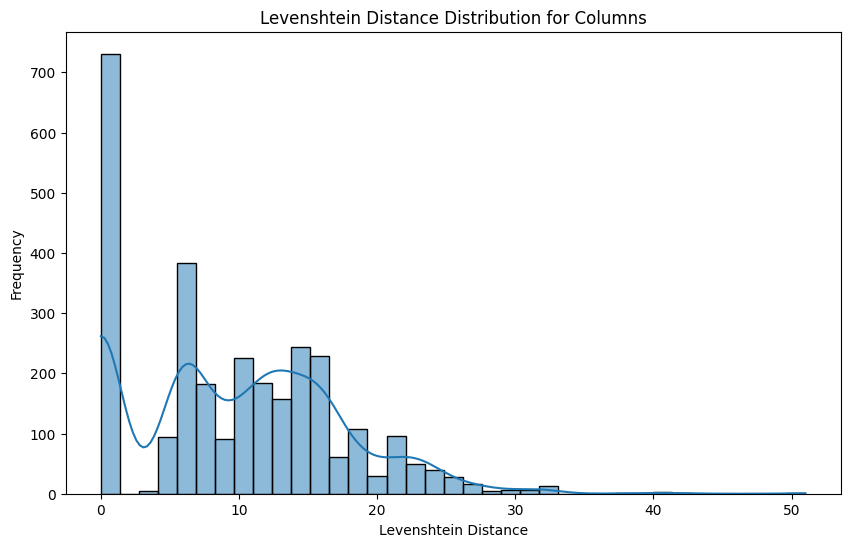

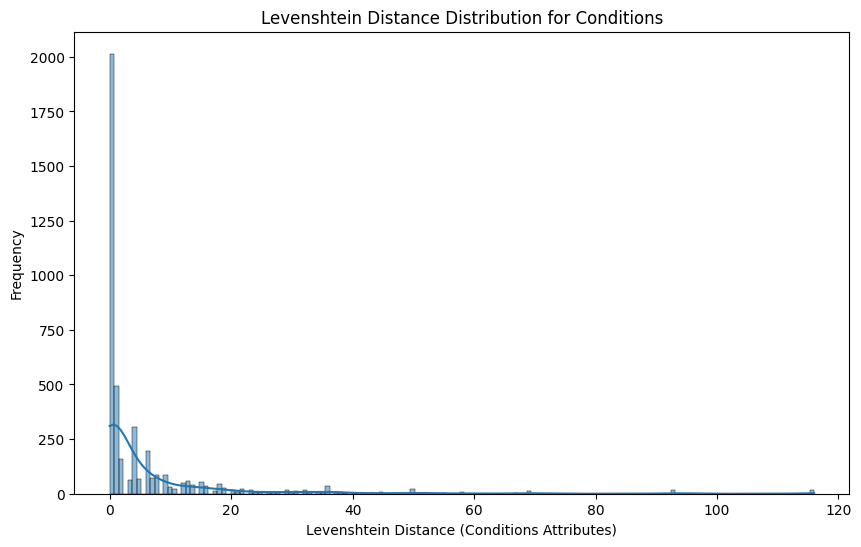

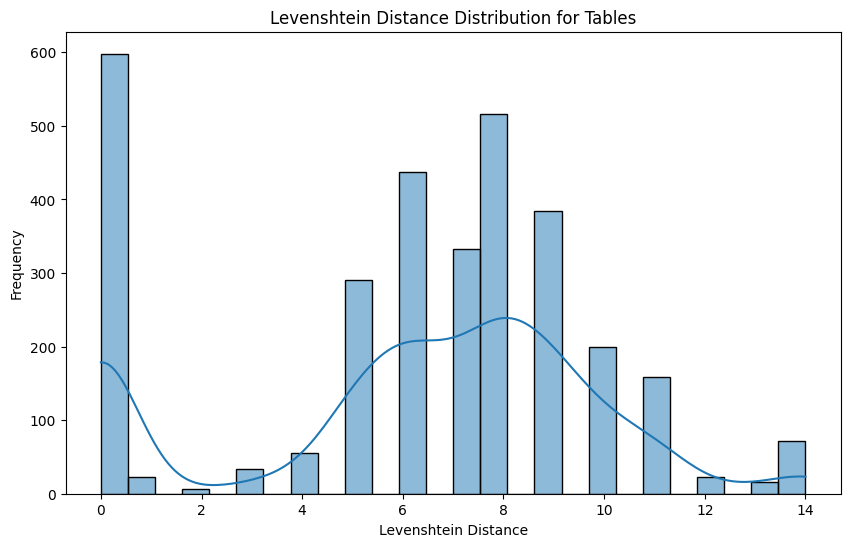

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Función para graficar las distribuciones de distancias
def plot_distance_distribution(df, title, x_label='Levenshtein Distance'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['LevenshteinDistance'], kde=True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Frequency')
    plt.show()

# Graficar las distribuciones de distancias
plot_distance_distribution(columns_df, 'Levenshtein Distance Distribution for Columns')
plot_distance_distribution(conditions_df, 'Levenshtein Distance Distribution for Conditions', 'Levenshtein Distance (Conditions Attributes)')
plot_distance_distribution(tables_df, 'Levenshtein Distance Distribution for Tables')


In [26]:
original_queries[0].condition

In [16]:
generated_queries[0].table

'departamento'